In [1]:
import random
import numpy as np
import copy
import time
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
random.seed(1)
n=10000 #number of objects
b=200 #number of bins
c=50

#Generate random locations
vj=random.choices(range(10, 100),k=n)
wj=random.choices(range(5, 20),k=n)

Exercise 1

Solution Encoding

The solution is represented with an n by b matrix where n is the number of items and b is the
number of containers. Entry (i,j) represents whether item i is assigned to container j with binary
encoding.

The code below randomly generates a solution that might not be feasible. Each item has 1/15 chance to be put in the containers with equal probability.

In [3]:
#input: n-number of items; b-number of containers
#output: result-a table of arrangement that might not be feasible
def generate_solution(n,b):
    result=np.zeros((n,b))
    for i in range(n):
        #whether to put the item in a knapsack
        a=random.randint(0,14)
        if a==1:
            #decide to put in which knapsack
            j=random.randint(0,b-1)
            result[i,j]=1
    return result

The code below fixes an infeasible solution by randomly removing items from the overweighted bags.

In [4]:
#input: x-a table of arrangement that might not be feasible c-capacity
#output: x-a table of a feasible arrangement
def fix(x,c):
    #check whether the result is valid
    n,b=x.shape
    valid=True
    overweight={}
    for i in range(b):
        weight=0
        for j in range(n):
            weight+=wj[j]*x[j,i]
        if weight>c:
            valid=False
            overweight[i]=weight

    #randomly remove items until it meets the constraint
    if valid==False:
        for i,w in overweight.items():
            in_bag=[]
            for j in range(n):
                if x[j,i]==1:
                    in_bag.append(j)
            while w>c:
                a=random.randint(0,len(in_bag)-1)
                x[in_bag[a],i]=0
                w-=wj[in_bag[a]]
                in_bag.pop(a)
    return x

The code below is used to convert a numpy result table to a more readable one.

In [5]:
def final_table(x):
        container=list(range(1,b+1))
        container.append('Total')
        package=[]
        for i in range(b):
            package.append([])
            for j in range(n):
                if x[j,i]==1:
                    package[i].append(j+1)
        package.append('')
        
        profits=[]
        weights=[]
        for i in range(b):
            profit=0
            weight=0
            for j in package[i]:
                profit+=vj[j-1]
                weight+=wj[j-1]
            profits.append(profit)
            weights.append(weight)
        profits.append(sum(profits))
        weights.append('')
        data={'Container':container,'Packages':package,'Profit':profits,'Weight':weights}
        return pd.DataFrame(data)    

Mutation

For each item, it has a 0.1% chance of mutation. After the mutation, it will either be placed in another bag, or just removed from the bag with equal probability.

In [6]:
def mutation(x):
    n,b=x.shape
    for i in range(n):
        #randomly choose a number among 1 to 1000, the number has 0.1% chance to be 100
        m=random.randint(1,1000)
        if m==100:
            for j in range(b):
                if x[i,j]==1:
                    x[i,j]=0
            #randomly choose a container to put the item in, if k=b, then just remove the item from the containers
            k=random.randint(0,b)
            if k!=b:
                x[i,k]=1
    return x
    

Fitness

Fitness in this case is just the total amount of profit.

In [7]:
#input: x-a table of a feasible arrangement
#output: profit-the fitness/total profit of this arrangement
def fitness(x):
    n,b=x.shape
    profit=0
    for i in range(n):
        for j in range(b):
            profit+=vj[i]*x[i,j]
    return profit

Evolution Algorithm

The initial population are uniformly randomly generated. 
The population size is 10. 
The selection strategy is roulette wheel selection. 
The reproduction strategy is mutation only, 5 offsprings will be reproduced each iteration.
The replacement strategy is generation replacement with elitism, only the best 10 among the 15 will make it to the next round. 

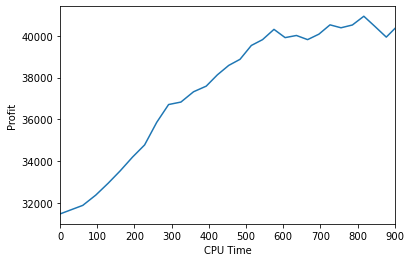

In [23]:
start=time.time()
#generate 10 initial solutions
population=[]
for i in range(10):
    a=generate_solution(n,b)
    d=fix(a,c)
    population.append(d)
fitness_list=[]
for i in population:
    fit=fitness(i)
    fitness_list.append(fit)
end=time.time()
time_list=[0]
value_list=[max(fitness_list)]

while end-start<60*15:
    #roulette wheel selection
    fitness_list=[]
    for i in population:
        fit=fitness(i)
        fitness_list.append(fit)
    k=sum(fitness_list)
    for i in range(len(fitness_list)):
        j=fitness_list[i]/k
        fitness_list[i]=j
    z=sum(fitness_list[0:9])
    fitness_list[-1]=1-z
    chosen=np.random.choice(np.arange(10),size=5,replace=False,p=fitness_list)

    #mutation
    for i in range(len(chosen)):
        j=mutation(population[chosen[i]])
        k=fix(j,c)
        population.append(k)

    #select the best 10 to next iteration
    dict={}
    for i in range(len(population)):
        fit=fitness(population[i])
        dict[i]=fit
    list1=sorted(dict.items(),key=lambda x:x[1])
    list2=[]
    for i in list1:
        list2.append(i[0])
    new_pop=[]
    for i in range(5,len(list2)):
        new_pop.append(population[list2[i]])
    best_val=list1[-1][1]
    population=copy.deepcopy(new_pop)
    end=time.time()
    time_list.append(end-start)
    value_list.append(best_val)

plt.xlabel('CPU Time')
plt.ylabel('Profit')
plt.xlim((0,60*15))
plt.plot(time_list,value_list)

Exercise 2

Crossover

The crossover here is uniform crossover with p=0.5

In [8]:
#input: x,y-two feasible arrangements act as parents
#output: result-the offspring
def crossover(x,y):
    n,b=x.shape
    result=np.zeros((n,b))
    for i in range(n):
        a=random.randint(0,1)
        if a==0:
            for j in range(b):
                result[i,j]=x[i,j]
        else:
            for j in range(b):
                result[i,j]=y[i,j]
    return result

The initial population are uniformly randomly generated. 
The population size is 10. 
The selection strategy is roulette wheel selection. 
The reproduction strategies are both mutation and crossover, 10 pairs of parents will be selected and 10 offsprings will be reproduced each iteration.
The replacement strategy is generation replacement with elitism, only the best 10 among the 20 will make it to the next round. 

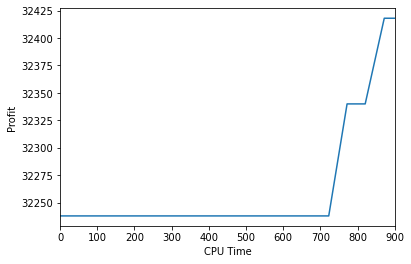

In [22]:
start=time.time()
#generate 10 initial solutions
population=[]
for i in range(10):
    a=generate_solution(n,b)
    d=fix(a,c)
    population.append(d)
fitness_list=[]
for i in population:
    fit=fitness(i)
    fitness_list.append(fit)
end=time.time()
time_list=[0]
value_list=[max(fitness_list)]

while end-start<60*15:
    #roulette wheel selection
    fitness_list=[]
    for i in population:
        fit=fitness(i)
        fitness_list.append(fit)
    k=sum(fitness_list)
    for i in range(len(fitness_list)):
        j=fitness_list[i]/k
        fitness_list[i]=j
    z=sum(fitness_list[0:9])
    fitness_list[-1]=1-z
    chosen_list=[]
    for i in range(10):
        chosen=np.random.choice(np.arange(10),size=2,replace=False,p=fitness_list)
        chosen_list.append(chosen)
    
    #crossover and mutation
    for i in chosen_list:
        a=crossover(population[i[0]],population[i[1]])
        d=mutation(a)
        k=fix(d,c)
        population.append(k)

    #select the best 10 to next iteration
    dict={}
    for i in range(len(population)):
        fit=fitness(population[i])
        dict[i]=fit
    list1=sorted(dict.items(),key=lambda x:x[1])
    list2=[]
    for i in list1:
        list2.append(i[0])
    new_pop=[]
    for i in range(10,len(list2)):
        new_pop.append(population[list2[i]])
    best_val=list1[-1][1]
    population=copy.deepcopy(new_pop)
    end=time.time()
    time_list.append(end-start)
    value_list.append(best_val)

plt.xlabel('CPU Time')
plt.ylabel('Profit')
plt.xlim((0,60*15))
plt.plot(time_list,value_list)

The terrible result is mainly because the algorithm only completed 29 iterations within 15 minutes. It is quite hard to deal with 20 200x10000 matrices.

In [24]:
print(len(value_list))
print(time_list)

29
[0, 61.059680700302124, 95.91146063804626, 129.50959539413452, 161.68154215812683, 194.81392240524292, 227.22301316261292, 259.8846731185913, 291.74643087387085, 324.83691906929016, 358.78021454811096, 392.8530766963959, 422.8408753871918, 453.4001307487488, 483.7050745487213, 514.125705242157, 544.2780554294586, 575.0245115756989, 604.9424910545349, 635.4020421504974, 665.3574371337891, 695.7372124195099, 725.6122715473175, 755.1851720809937, 785.7244870662689, 816.5570225715637, 846.7841718196869, 876.9036066532135, 907.1397352218628]


As you can see, it takes about half a minute to complete 1 iteration.